## Setting up the environment
This [Jupyter Notebook](https://jupyterlab.readthedocs.io/en/latest/) was made to run on Google Colab. Please read [instructions on Google Colab](https://medium.com/swlh/the-best-place-to-get-started-with-ai-google-colab-tutorial-for-beginners-715e64bb603b) if you want more information regarding Google Colab.

Some notes on Google Colab:

- Processes in Google Colab won't run forever. These may be terminated at any time when the platform is crowded, and will definitely terminate after 12 hours. To maintain persistency, you can attach the session to Google Drive below so that the your notebook (and your modifications) are saved.
- You can enable GPU or TPU support! You can find this option under Runtime -> Change runtime type.
- After installing dependencies, you need to restart the runtime in order to actually use them.

### Installing the dependencies
Some dependencies need to be installed for the code to work.

In [1]:
!pip install matplotlib > /dev/null
!pip install pandas > /dev/null
!pip install numpy > /dev/null
!pip install math > /dev/null
!pip install networkx > /dev/null
!pip install geopandas > /dev/null

ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math


Next, all libraries containing helper functions are imported.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import math
import networkx.algorithms.approximation as nx_app

You need to have a shortcut in 'My Drive' to run this code

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/ML Workshop/'

Mounted at /content/drive
/content/drive/MyDrive/ML Workshop


Reading the database of spanish cities

In [5]:
database = pd.read_csv('es.csv', header = 0)
database.sort_values(by='population_proper', ascending=False)
database.drop(database[database['admin_name'] == 'Balearic Islands'].index, inplace = True)
database.drop(database[database['admin_name'] == 'Canary Islands'].index, inplace = True)
database.drop(database[database['admin_name'] == 'Ceuta'].index, inplace = True)
database.drop(database[database['admin_name'] == 'Melilla'].index, inplace = True)
database.reset_index(drop=True, inplace=True)
sample = database[:100]
sample

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Madrid,40.4169,-3.7033,Spain,ES,Madrid,primary,6211000,3266126
1,Barcelona,41.3825,2.1769,Spain,ES,Catalonia,admin,4800000,1620343
2,Sevilla,37.2400,-5.9900,Spain,ES,Andalusia,admin,1100000,681998
3,Málaga,36.7194,-4.4200,Spain,ES,Andalusia,minor,967250,579076
4,Valencia,39.4700,-0.3764,Spain,ES,Valencia,admin,792492,792492
...,...,...,...,...,...,...,...,...,...
95,Mairena del Aljarafe,37.3333,-6.0667,Spain,ES,Andalusia,NaN,47161,47161
96,Figueras,42.2667,2.9650,Spain,ES,Catalonia,NaN,47088,47088
97,Gavá,41.3072,2.0039,Spain,ES,Catalonia,NaN,46974,46974
98,Esplugas de Llobregat,41.3767,2.0858,Spain,ES,Catalonia,NaN,46777,46414


Definition of the Christofides Algorithm.

The Christofides algorithm is an approximation algorithm for the metric Traveling Salesman Problem (TSP) with a guarantee of obtaining a solution within 3/2 times the optimal solution. Here's a step-by-step explanation of the Christofides algorithm:

**Input:** A complete undirected graph $G=(V,E)$ with non-negative edge weights
(distances).

**Steps:**

1.   Find a minimum spanning tree $T$.This can be done, for example, using Kruskal's or Prim's algorithm.
2.   Let $O$ be the set of nodes with odd degree in $T$. Find a minimum-cost perfect matching $M$ on $O$.
3. Add the set of edges of $M$ to $T$. Find an Eulerian tour. This circuit visits each edge exactly once.
4. Shortcut the Eulerian tour by shortcutting (removing repeated vertices) and reconnecting the remaining vertices. This step ensures that each vertex is visited exactly once. We will obtain a Hamiltonian circuit

The resulting Hamiltonian circuit is a solution to the TSP instance. It's important to note that while the Christofides algorithm guarantees a 3/2 approximation ratio, finding an exact solution to the TSP is an NP-hard problem. Christofides' algorithm provides a good compromise between solution quality and computational efficiency for certain instances of the TSP.

To read more about Christofides Algorithm, [click here](https://bochang.me/blog/posts/tsp/)


In [7]:
def compute_distances(cities):
    distances = []
    for from_city in cities:
        row = []
        for to_city in cities:
            row.append(111*np.linalg.norm(from_city - to_city))
        distances.append(row)
    return np.array(distances)


def route_length(distances, route):
    length = 0
    for i in range(len(route)):
        length += distances[route[i], route[(i + 1) % len(route)]]
    return length


def plot_route(cities, route, distances):

    spain = gpd.read_file('./Spain/')

    length = route_length(distances, route)

    plt.figure(figsize=(12, 8))
    spain.plot(ax=plt.gca(), color='lightgray',zorder=0)
    plt.scatter(x=cities[:, 0], y=cities[:, 1], s=200, zorder=10)
    for i in range(len(cities)):
        plt.text(cities[i][0], cities[i][1], str(i), horizontalalignment='center', verticalalignment='center', size=8,
                 c='white',zorder=11)
    for i in range(len(route)):
        plt.plot([cities[route[i]][0], cities[route[(i + 1) % len(route)]][0]],
                 [cities[route[i]][1], cities[route[(i + 1) % len(route)]][1]], 'k', zorder=5)
    if len(route)>0:
        plt.title(f'Visiting {len(route)} cities in {length:.2f} km', size=16)
    else:
        plt.title(f'{len(cities)} cities', size=16)

    plt.xlabel('Longitude (º)')
    plt.ylabel('Latitude (º)')
    plt.xlim(left=-10)
    plt.xlim(right=4)
    plt.ylim(top = 44)
    plt.ylim(bottom = 36)
    plt.show()

In [6]:
def solve (cities):
  coordinates = np.array([[sample['lng'][i],sample['lat'][i]] for i in range (len(sample))])

  G = nx.Graph()
  nodes = np.arange (0,len(sample))
  G.add_nodes_from(nodes)

  positions = {node:coordinate for node, coordinate in zip(nodes,coordinates)}

  for i in nodes:
      for j in nodes:
            if i!=j:
                G.add_edge(i, j)

  H = G.copy()

  #Calculating the distances between the nodes as edge's weight.
  for i in range(len(positions)):
      for j in range(i + 1, len(positions)):

          #Multidimensional Euclidean distan
            dist = math.hypot(positions[i][0] - positions[j][0], positions[i][1] - positions[j][1])
            dist = dist
            G.add_edge(i, j, weight=dist)

  cycle = nx_app.christofides(G, weight="weight")
  edge_list = list(nx.utils.pairwise(cycle))

  return cycle


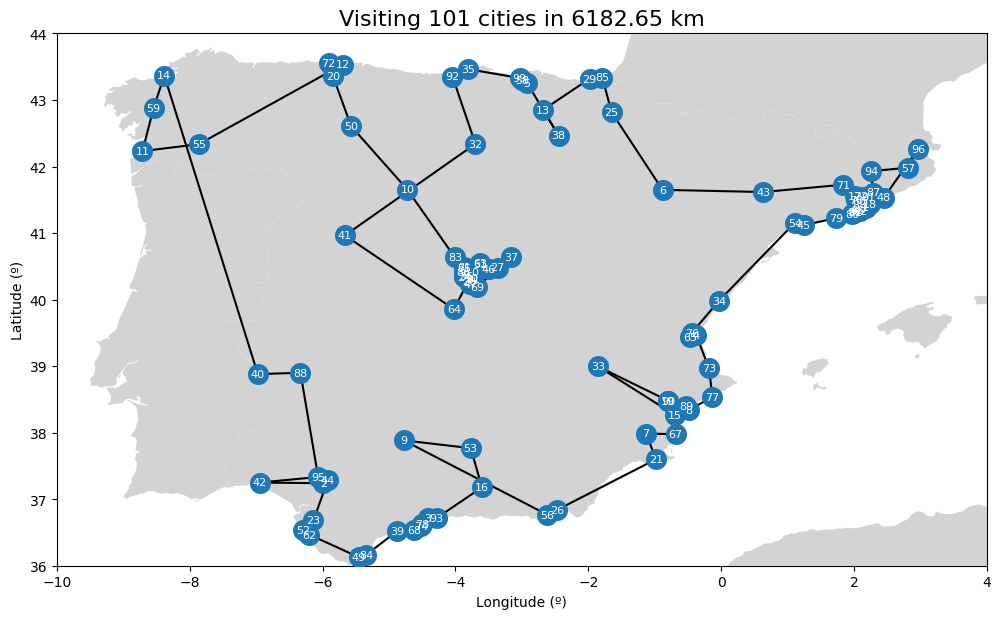

In [8]:
cities = np.array([[sample['lng'][i],sample['lat'][i]] for i in range (len(sample))])
distances = compute_distances (cities = cities)

cycle = solve(cities)

plot_route(cities = cities, route=cycle, distances=distances)